In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.optimize as so
import matplotlib.pyplot as plt

/home/cytech/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Statistics over: 1000 simulations for symmetric mode

Average PnL: 59.14
Std Profit: 15.92
Average inventory: 0.06
Std inventory: 8.60


Statistics over: 1000 simulations for inventory mode

Average PnL: 56.12
Std Profit: 5.29
Average inventory: -0.02
Std inventory: 0.93




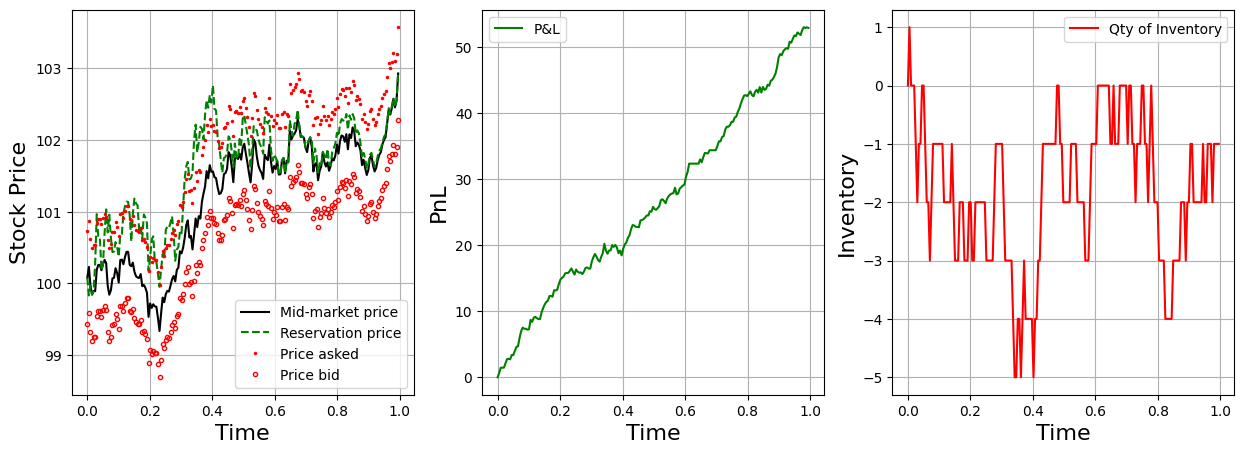

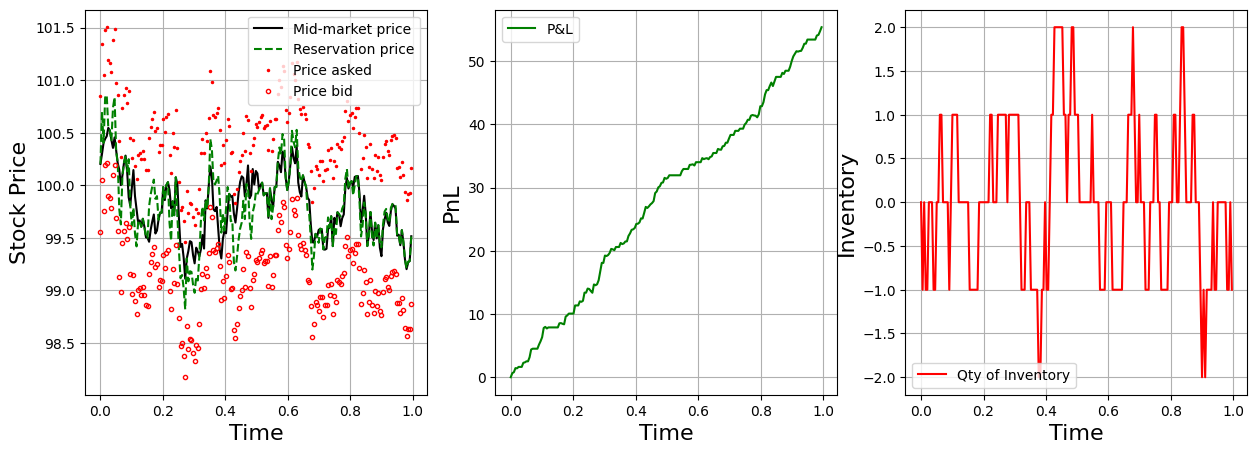

In [61]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
def brownian_motion(s_0, n, sigma, dt):
    """Simulate prices with brownian motion and an upward drift
    """
    r = ss.norm.rvs(size=(n,), scale=sigma*np.sqrt(dt))

    res = np.empty(r.shape)

    np.cumsum(r, axis=-1, out=res)
    res += np.array([s_0])

    #slight upward drift
    res = [x + 0.01 * ind for ind,x in enumerate(res)]
    return res


# Parameters

# Initial Price
s_0 = 100
# Time. normalized to 1
T = 1.0
# Volatility
sigma = 2
# number of time steps
N = 200
# single time step. time fraction
dt = T / N
# inventory Risk aversion
gamma = 0.1
# order book liquidity
k = 1.5


number_of_simulation = 1000

pnl_of_simulation = np.zeros((number_of_simulation))
final_inventory = np.zeros((number_of_simulation))

M = s_0/200
A = 1./dt/np.exp(k*M/2)

# begin monte carlo simulation
for mode in ['symmetric', 'inventory']:

    for simulation in range(number_of_simulation):
        prices = brownian_motion(s_0, N, sigma, dt) # mid-price
        time = np.linspace(0.0, T, N)

        pnl = np.zeros((N))
        cash = np.zeros((N))
        inventory = np.zeros((N))
        reserve_price = np.zeros((N))
        r_optimal_ask = np.zeros((N))
        r_optimal_bid = np.zeros((N))

        for step in range(N-1):

            # limited time horizon
            reserve_price[step] = prices[step] - inventory[step] * gamma * (sigma ** 2) * (T-dt*step)
            reserve_spread = (2/gamma) * np.log(1 + gamma/k)

            if mode == 'symmetric':
                # symmetric strategy (fixed around mid-price)
                r_optimal_ask[step] = prices[step] + reserve_spread / 2
                r_optimal_bid[step] = prices[step] - reserve_spread / 2
                optimal_distance_ask = r_optimal_ask[step] - prices[step]
                optimal_distance_bid = prices[step] - r_optimal_bid[step]
            elif mode == 'inventory':
                #i nventory strategy (fixed around reservation price)
                r_optimal_ask[step] = reserve_price[step] + reserve_spread / 2
                r_optimal_bid[step] = reserve_price[step] - reserve_spread / 2
                optimal_distance_ask = -gamma*inventory[step]*(sigma**2) + (1/gamma)*np.log(1 + (gamma/k))
                optimal_distance_bid = gamma*inventory[step]*(sigma**2) + (1/gamma)*np.log(1 + (gamma/k))
            # print(optimal_distance_ask,optimal_distance_bid)

            # A_ask =  1./dt/np.exp(k*optimal_distance_ask)
            # A_bid =  1./dt/np.exp(k*optimal_distance_bid)


            # exponential arrival rates
            lambda_ask = A * np.exp(-k*optimal_distance_ask)
            lambda_bid = A * np.exp(-k*optimal_distance_bid)

            # probability of bid and ask
            ask_probability = 1 - math.exp(-lambda_ask*dt)
            bid_probability = 1 - math.exp(-lambda_bid*dt)

            ask_amount = 0
            bid_amount = 0
            if random.random() < ask_probability:
                ask_amount = 1
            if random.random() < bid_probability:
                bid_amount = 1

            # Transact. change inventory, cash, and pnl
            inventory[step+1] = inventory[step] - ask_amount + bid_amount
            cash[step+1] = cash[step] + r_optimal_ask[step]*ask_amount - r_optimal_bid[step]*bid_amount
            pnl[step+1] = cash[step+1] + inventory[step+1]*prices[step]

        #store final pnl and inventory
        pnl_of_simulation[simulation] = pnl[-1]
        final_inventory[simulation] = inventory[-1]


    # calculate statistics
    print(f'Statistics over: {number_of_simulation} simulations for {mode} mode\n')

    print("Average PnL: %.2f"% np.mean(pnl_of_simulation))
    print("Std Profit: %.2f"% np.std(pnl_of_simulation))
    print("Average inventory: %.2f"% np.mean(final_inventory))
    print("Std inventory: %.2f\n\n"% np.std(final_inventory))

    # save plot
    f = plt.figure(figsize=(15, 5))
    f.add_subplot(1,3, 1)
    plt.plot(time[:-1], prices[:-1], color='black', label='Mid-market price')
    plt.plot(time[:-1], reserve_price[:-1], color='green', linestyle='dashed', label='Reservation price')
    plt.plot(time[:-1], r_optimal_ask[:-1], color='red', linestyle='', marker='.', label='Price asked', markersize='3')
    plt.plot(time[:-1], r_optimal_bid[:-1], color='red', linestyle='', marker='o', markerfacecolor = 'none',label='Price bid', markersize='3')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Stock Price', fontsize=16)
    plt.grid(True)
    plt.legend()

    f.add_subplot(1,3, 2)
    plt.plot(time[:-1], pnl[:-1], color='green', label='P&L')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('PnL', fontsize=16)
    plt.grid(True)
    plt.legend()

    f.add_subplot(1,3, 3)
    plt.plot(time[:-1], inventory[:-1], color='red', label='Qty of Inventory')
    plt.xlabel('Time', fontsize=16)
    plt.ylabel('Inventory', fontsize=16)
    plt.grid(True)
    plt.legend()

    f.savefig(f'result_{mode}.png')

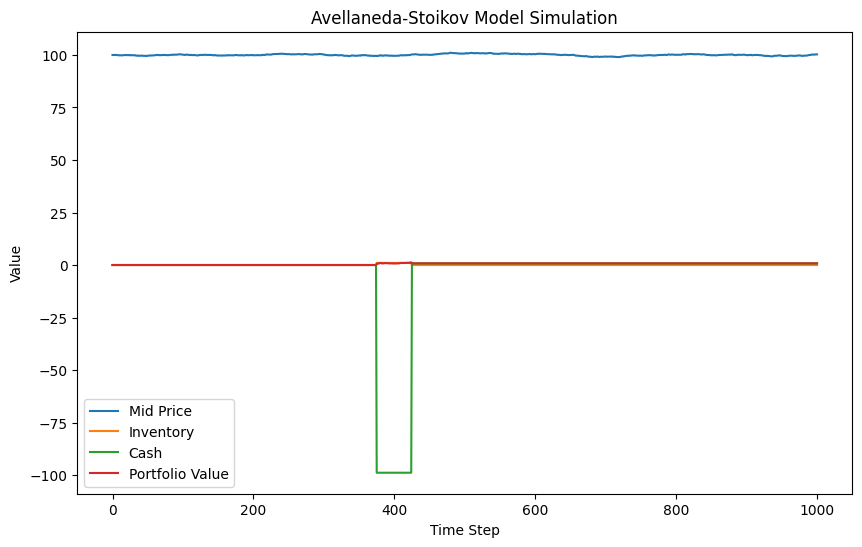

In [ ]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

def price_fluctuation(S_0, N, T, sigma):
    dt = T / N
    b_increments = ss.norm.rvs(size=N, scale=np.sqrt(dt))
    b_t = np.cumsum(b_increments)
    b_t = np.insert(b_t, 0, 0)
    S = S_0 + sigma * b_t
    return S

def optimal_spread(gamma, k, T,t):
    return 0.5*gamma**2*(T-t) + (1 / gamma) * np.log(1 + gamma / k)

def trading_intensity(mid_price, sigma, gamma, k, T, t, q_current, lambda_ask, lambda_bid, delta, dt):
    # Compute reservation price
    r = mid_price - q_current * gamma * sigma**2 * (T - t)
    # Compute distances for ask and bid from market mid-price
    delta_ask = delta - q_current * gamma * sigma**2 * (T - t)
    delta_bid = delta + q_current * gamma * sigma**2 * (T - t)
    
    # Compute intensities with time scaling
    intensity_ask = lambda_ask * np.exp(-k * delta_ask) * dt
    intensity_bid = lambda_bid * np.exp(-k * delta_bid) * dt
    
    # Generate number of orders (buy/sell)
    N_b = ss.poisson.rvs(intensity_ask)  # Buy orders hitting ask
    N_a = ss.poisson.rvs(intensity_bid)  # Sell orders hitting bid
    
    # Calculate cash flow and inventory change
    cash_jump = N_b * (r + delta) - N_a * (r - delta)
    q_change = N_a - N_b
    
    return cash_jump, q_change


def bid_ask(mid_price,inventory, gamma,delta, T, t):
    r = mid_price - inventory * gamma * sigma**2 * (T - t)
    ask = r + delta
    bid = r - delta
    return ask, bid



def simulate_trading(S_0, N, T, sigma, gamma, k, lambda_ask, lambda_bid):
    dt = T / N
    S = price_fluctuation(S_0, N, T, sigma)
    q = np.zeros(N + 1)
    cash = np.zeros(N + 1)
    
    for t in range(N):
        current_time = t * dt
        mid_price = S[t]
        q_current = q[t]
        delta = optimal_spread(gamma, k, T, current_time)
        bid, ask = bid_ask(mid_price, q_current, gamma, delta, T, current_time)
        cash_jump, q_change = trading_intensity(mid_price, sigma, gamma, k, T, current_time, q_current,
                                               lambda_ask, lambda_bid, delta, dt)
        q[t + 1] = q_current + q_change
        cash[t + 1] = cash[t] + cash_jump
    
    portfolio_value = cash + q * S
    return S, q, cash, portfolio_value, bid, ask

if __name__ == '__main__':
    S_0 = 100
    N = 1000
    T = 1
    sigma = 2
    gamma = 0.5
    k = 1.5
    lambda_ask = 5
    lambda_bid = 5

    S, q, cash, portfolio_value = simulate_trading(S_0, N, T, sigma, gamma, k, lambda_ask, lambda_bid)

    plt.figure(figsize=(10, 6))
    plt.plot(S, label='Mid Price')
    plt.plot(q, label='Inventory')
    plt.plot(cash, label='Cash')
    plt.plot(portfolio_value, label='Portfolio Value')
    plt.legend()
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.title('Avellaneda-Stoikov Model Simulation')
    plt.show()